In [1]:
from openslide import OpenSlide
import os
import numpy as np
import xml.etree.ElementTree as ET
import scipy
import pandas as pd
from matplotlib import pyplot as plt
import cv2
from time import time
from rgb2hed_v1 import separate_stains
from skimage.measure import label,find_contours,regionprops
from skimage.morphology import remove_small_objects
from sklearn.neighbors import NearestNeighbors

In [2]:
# xml_path = absolute filepath of xml
# mdict = 2D coordinates of annotation by class and object
def readxml(xml_path):
    start = time()
    tree = ET.parse(xml_path)
    root = tree.getroot()
    x = np.array([])
    y = np.array([])
    obj = np.array([])
    classID = np.array([])
    for Annotation in root.iter('Annotation'):
      for Region in Annotation.iter('Region'):
         xx = np.array([int(Vertex.get('X')) for Vertex in Region.iter('Vertex')])
         yy = np.array([int(Vertex.get('Y')) for Vertex in Region.iter('Vertex')])
         objj = np.array([int(Region.get('Id'))]*len(xx))
         classIDD = np.array([int(Annotation.get('Id'))]*len(xx))
         x = np.concatenate((x,xx),axis=None)
         y = np.concatenate((y,yy),axis=None)
         obj = np.concatenate((obj,objj),axis=None)
         classID = np.concatenate((classID,classIDD),axis=None)
    # print('number of coordinates in annotation : ',len(x))
    mdict = {'x':x.astype(int),'y':y.astype(int),'objID':obj.astype(int),'classID':classID.astype(int)}
    print('readxml took {:.2f} sec'.format(time()-start))
    return pd.DataFrame(mdict)

In [3]:
# open svs and xml
svs_src = r'\\kukissd\research\aging\data\svs'
fn = 'Wirtz.Denis_OTS-19_5021-006'
svs_path = os.path.join(*[svs_src,fn+'.svs'])
xml_path = os.path.join(*[svs_src,fn+'.xml'])
if os.path.exists(svs_path): svs = OpenSlide(svs_path)
if os.path.exists(xml_path): xml = readxml(xml_path)
svs.level_dimensions

readxml took 0.91 sec


((80885, 46423), (20221, 11605), (5055, 2901), (2527, 1450))

In [4]:
obj_count_per_class = [len(np.unique(xml['objID'][xml['classID']==classid])) for classid in np.unique(xml['classID'])]
sort_index = np.argsort(obj_count_per_class)
# first element in this list is collagen index
sort_index

array([1, 0], dtype=int64)

c:\users\kuki\anaconda3\envs\tf21\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


mask generation 4.306557893753052 seconds


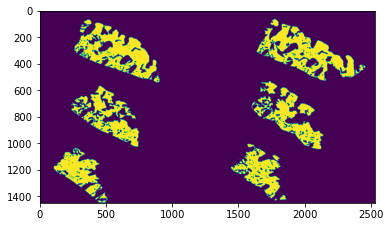

In [5]:
# find reticular dermis of each section
start = time()
mask = np.zeros(svs.level_dimensions[-1][::-1])
for classidx, classid in enumerate(np.unique(xml['classID'])[sort_index]):
    for objidx, objid in enumerate(np.unique(xml['objID'])):
        object = xml[xml['classID']==classid][xml['objID']==objid]
        if len(object)<1: continue
        x = object['x']/svs.level_downsamples[-1]
        y = object['y']/svs.level_downsamples[-1]
        vertex = np.array([[i,j] for i,j in zip(x,y)]).astype(np.int32)
        cv2.fillPoly(mask,[vertex],color=int(classid-1))
print('mask generation',time()-start,'seconds')
plt.imshow(mask)
# resize back to 20x if you want, not recommended for the data size
# mask2 = cv2.resize(mask,dsize=svs.level_dimensions[0],interpolation=cv2.INTER_CUBIC)

In [6]:
for objidx, objid in enumerate(np.unique(xml['objID'])[0:1]):
    object = xml[xml['classID']==np.unique(xml['classID'])[sort_index][0]][xml['objID']==objid]
    x = object['x']
    y = object['y']
    [xmin,xmax,ymin,ymax] = [np.min(x),np.max(x),np.min(y),np.max(y)]
    [width,height] = [xmax-xmin,ymax-ymin]
    start=time()
    region = svs.read_region(location=(xmin,ymin),level=0,size=(width,height)).convert("RGB")
    print('openslide',time()-start,'seconds elapsed')
    start=time()
    [xmin_small,xmax_small,ymin_small,ymax_small] = [np.around(_/svs.level_downsamples[-1]).astype(int)
                                                     for _ in [xmin,xmax,ymin,ymax]]
    region_mask = mask[ymin_small:ymax_small,xmin_small:xmax_small]
    region_mask = cv2.resize(region_mask, dsize=region.size, interpolation=cv2.INTER_CUBIC)
    ret,region_mask = cv2.threshold(region_mask,0.5,1,cv2.THRESH_BINARY)
    region_mask = np.repeat(region_mask[:, :, np.newaxis], 3, axis=2)
    region = np.array(region)
    region[region_mask==0] = 255
    region = region/255
    region = region.astype(np.float16)
    print('masking',time()-start,'seconds elasped')

c:\users\kuki\anaconda3\envs\tf21\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


openslide 35.202911376953125 seconds elapsed
masking 11.211028337478638 seconds elasped


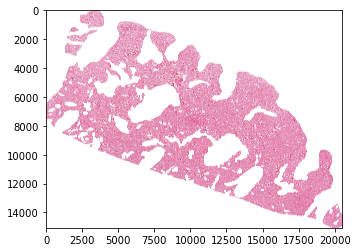

In [7]:
plt.imshow(region.astype(np.float32))

In [8]:
subregion = region[1000:4000,1000:4000]

In [9]:
# RGB to Haematoxylin-Eosin-DAB (HED) color space conversion.
# Hematoxylin + Eosin + DAB
rgb_from_hed = np.array([[0.650, 0.704, 0.286],
                         [0.072, 0.990, 0.105],
                         [0.268, 0.570, 0.776]])
hed_from_rgb = scipy.linalg.inv(rgb_from_hed)
ihc_hed = separate_stains(subregion, hed_from_rgb)



In [10]:
# Hematoxylin + Eosin
rgb_from_hed2 = np.array([[0.650, 0.704, 0.286],
                         [0.072, 0.990, 0.105],
                         [0.0, 0.0, 0.0]])
rgb_from_hed2[2, :] = np.cross(rgb_from_hed2[0, :], rgb_from_hed2[1, :])
hed_from_rgb2 = scipy.linalg.inv(rgb_from_hed2)
ihc_hed2 = separate_stains(subregion, hed_from_rgb2)

In [11]:
# Hematoxylin + DAB
rgb_from_hed3 = np.array([[0.650, 0.704, 0.286],
                         [0.268, 0.570, 0.776],
                         [0.0, 0.0, 0.0]])
rgb_from_hed3[2, :] = np.cross(rgb_from_hed3[0, :], rgb_from_hed3[1, :])
hed_from_rgb3 = scipy.linalg.inv(rgb_from_hed3)
ihc_hed3 = separate_stains(subregion, hed_from_rgb3)

In [12]:
# Hematoxylin + AEC
rgb_from_hed4 = np.array([[0.650, 0.704, 0.286],
                         [0.2743, 0.6796, 0.6803],
                         [0.0, 0.0, 0.0]])
rgb_from_hed4[2, :] = np.cross(rgb_from_hed4[0, :], rgb_from_hed4[1, :])
rgb_from_hed4 = scipy.linalg.inv(rgb_from_hed4)
ihc_hed4 = separate_stains(subregion, rgb_from_hed4)

In [13]:
# Hematoxylin + PAS
rgb_from_hed5 = np.array([[0.644211, 0.716556, 0.266844],
                         [0.175411, 0.972178, 0.154589],
                         [0.0, 0.0, 0.0]])
rgb_from_hed5[2, :] = np.cross(rgb_from_hed5[0, :], rgb_from_hed5[1, :])
rgb_from_hed5 = scipy.linalg.inv(rgb_from_hed5)
ihc_hed5 = separate_stains(subregion, rgb_from_hed5)

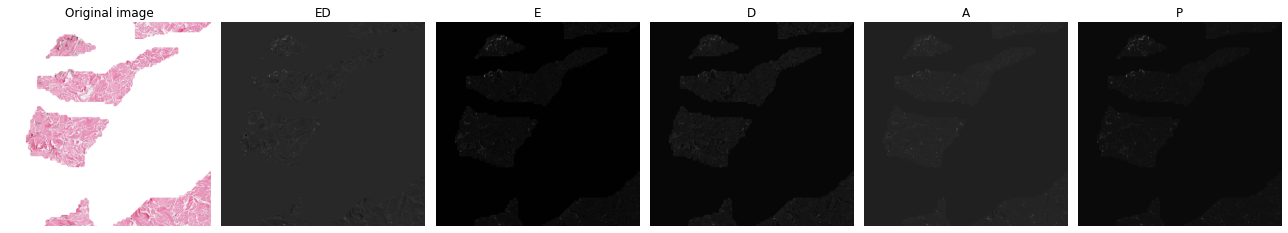

In [14]:
# create linear segmented colormap from a sequence of colors. The sequence evenly transitions from color A to B.
# give (value,color) tuples for uneven range.
# cmap_hema = mpl.colors.LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
# cmap_dab = mpl.colors.LinearSegmentedColormap.from_list('mycmap', ['white', 'saddlebrown'])
# cmap_eosin = mpl.colors.LinearSegmentedColormap.from_list('mycmap', ['darkviolet', 'white'])

fig, axes = plt.subplots(1, 6, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(subregion.astype(np.float32))
ax[0].set_title("Original image")

ax[1].imshow(ihc_hed[:, :, 0], cmap='gray')
ax[1].set_title("ED")

ax[2].imshow(ihc_hed2[:, :, 0], cmap='gray')
ax[2].set_title("E")

ax[3].imshow(ihc_hed3[:, :, 0], cmap='gray')
ax[3].set_title("D")

ax[4].imshow(ihc_hed4[:, :, 0], cmap='gray')
ax[4].set_title("A")

ax[5].imshow(ihc_hed5[:, :, 0], cmap='gray')
ax[5].set_title("P")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

Text(0.5, 1.0, 'ED')

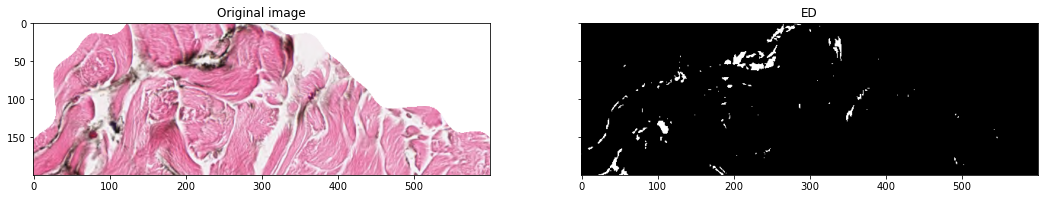

In [15]:
#1 intensity thresholding
threshold = 0.3
Hema_norm = cv2.normalize(ihc_hed[:, :, 0], None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
Hema_norm[Hema_norm<threshold]=0
Hema_norm[Hema_norm>threshold]=1

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
ax = axes.ravel()


a=200
b=400
c=700
d=1300

rgb= subregion.astype(np.float32)[a:b,c:d]
bw = Hema_norm[a:b,c:d]

ax[0].imshow(rgb)
ax[0].set_title("Original image")

ax[1].imshow(bw, cmap='gray')
ax[1].set_title("ED")

In [16]:
# import cv2
# import numpy as np
# from matplotlib import pyplot as plt
# np.save('testarea.npy',bw)
# testarea = np.load('testarea.npy')
# plt.imshow(testarea)

In [128]:
labeled_bw = label(bw).astype(np.uint8)

In [111]:
np.unique(labeled_bw)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105], dtype=uint8)

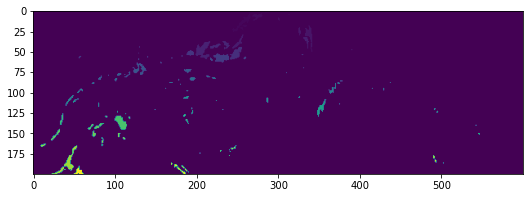

In [112]:
fig,ax = plt.subplots(figsize=(10,3))
plt.imshow(labeled_bw)

Text(0.5, 1.0, 'Area')

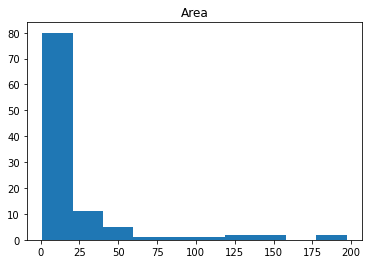

In [129]:
prop = regionprops(labeled_bw)
plt.hist([_['area'] for _ in prop])
plt.title('Area')

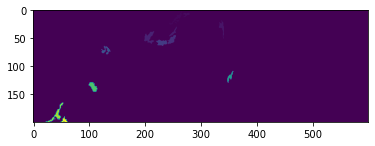

In [130]:
#2 size filter
remove_small_objects(labeled_bw,min_size=50,connectivity=1,in_place=True)
plt.imshow(labeled_bw)

Text(0.5, 1.0, 'Area')

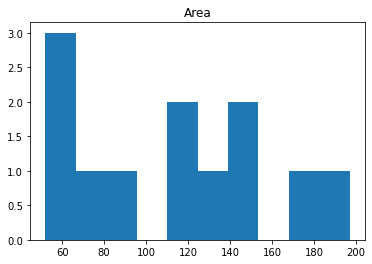

In [115]:
prop = regionprops(labeled_bw)
plt.hist([_['area'] for _ in prop])
plt.title('Area')

In [131]:
#3 AR filter
minAR = 2
maxAR = 100
for prop in regionprops(labeled_bw):
    AR = prop['major_axis_length']/prop['minor_axis_length']
    if AR<minAR: labeled_bw[labeled_bw==prop.label]=0
    if AR>maxAR: labeled_bw[labeled_bw==prop.label]=0

Text(0.5, 1.0, 'Aspect Ratio')

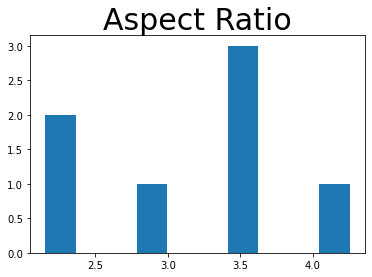

In [132]:
prop = regionprops(labeled_bw)
ARs = [_['major_axis_length']/_['minor_axis_length'] for _ in prop]
plt.hist(ARs)
plt.title('Aspect Ratio',fontsize=30)

Text(0.5, 1.0, 'Circularity')

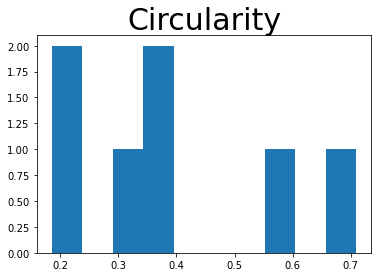

In [135]:
SFs = [4*np.pi*_['area']/_['perimeter']**2 for _ in prop]
plt.hist(SFs)
plt.title('Circularity',fontsize=30)

[ 0  2  6  8 14 60 75 90]


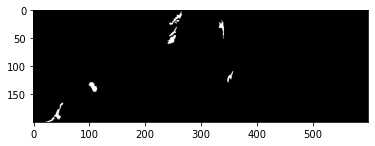

In [134]:
print(np.unique(labeled_bw))
plt.imshow((labeled_bw>0)*1,cmap='gray')

In [138]:
#4 SF filter
minSF = 0.1
maxSF = 0.6
print(np.unique(labeled_bw))
for prop in regionprops(labeled_bw):
    SF = 4*np.pi*prop['area']/prop['perimeter']**2
    if SF<minSF: labeled_bw[labeled_bw==prop.label]=0; print(prop.label)
    if SF>maxSF: labeled_bw[labeled_bw==prop.label]=0; print(prop.label)
print(np.unique(labeled_bw))

[ 0  2  6  8 60 90]
[ 0  2  6  8 60 90]


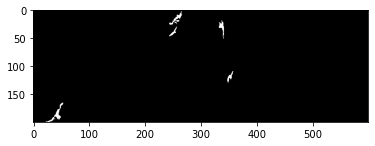

In [139]:
plt.imshow((labeled_bw>0)*1,cmap='gray')

(array([2., 0., 0., 0., 0., 1., 0., 0., 0., 2.]),
 array([0.18592022, 0.2065704 , 0.22722058, 0.24787076, 0.26852094,
        0.28917112, 0.3098213 , 0.33047148, 0.35112167, 0.37177185,
        0.39242203]),
 <BarContainer object of 10 artists>)

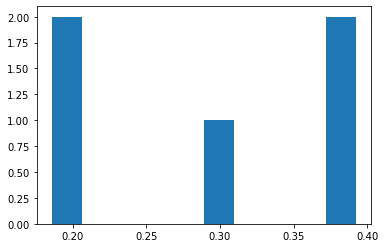

In [140]:
prop = regionprops(labeled_bw)
SFs = [4*np.pi*_['area']/_['perimeter']**2 for _ in prop]
plt.hist(SFs)

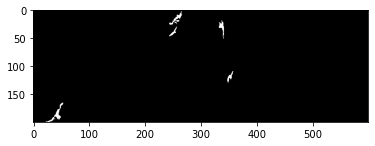

In [228]:
plt.imshow((labeled_bw>0)*1,cmap='gray')

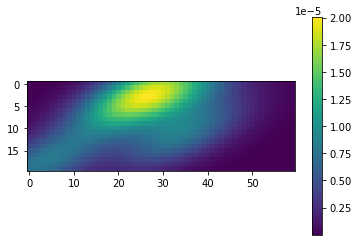

In [180]:
# plot density map
# x = [_.centroid[0] for _ in prop]
# y = [_.centroid[1] for _ in prop]
# xx, yy = np.mgrid[0:labeled_bw.shape[0]:labeled_bw.shape[0]*0.1j, ymin:labeled_bw.shape[1]:labeled_bw.shape[1]*0.1j]
# positions = np.vstack([xx.ravel(), yy.ravel()])
# values = np.vstack([x, y])
# kernel = scipy.stats.gaussian_kde(values)
# f = np.reshape(kernel(positions).T, xx.shape)
# fig,ax=plt.subplots()
# pos = ax.imshow(f)
# fig.colorbar(pos, ax=ax)

[(15.439716312056738, 256.6595744680851),
 (30.464912280701753, 338.0438596491228),
 (39.440677966101696, 250.96610169491527),
 (119.12328767123287, 352.3013698630137),
 (185.7967032967033, 42.1978021978022)]

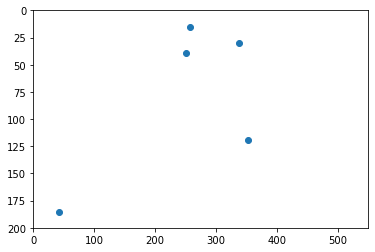

In [198]:
x = [_.centroid[0] for _ in prop]
y = [_.centroid[1] for _ in prop]
plt.scatter(y,x)
plt.xlim([0,550])
plt.ylim([200,0])
X = [[_.centroid[0],_.centroid[1]] for _ in prop]
Y = [_.centroid for _ in prop]

In [229]:
# distance filter
min_dist_to_neighbor = 50
nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(Y)
distances, indices = nbrs.kneighbors(X)
close_objects = np.array(prop)[distances[:,1]<min_dist_to_neighbor]
for close_object in close_objects:
    labeled_bw[labeled_bw==close_object.label]=0

AttributeError: 'numpy.ndarray' object has no attribute 'label'

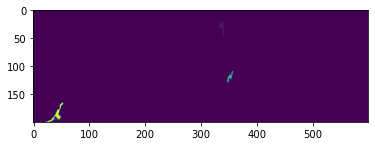

In [232]:
plt.imshow(labeled_bw)